# <ins>COVID Vaccine Twitter Analysis</ins>

# Exploratory Data Analysis

## Overview
With any form of unstructured text data, there exists an abundance of information to extrapolate. In this case, working with tweets about the Covid vaccine, the concepts I wanted explore are what the breakdown of sentiment over time has been this year, what sorts of words are common in each of the three classes (positive, negative, neutral) and how they resemble one another or more likely differ, and ideally extract the distict features from each to help address the lack of trust in the vaccines that are now FDA approved.

Without having the time or the resources to manually tag all of the tweets I scraped, I began this process by using Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://github.com/cjhutto/vaderSentiment)) to establish a baseline measure for classification. During the modeling process this will serve as my target variable when predicting classes on my test set and even tweets from future date ranges.

Using Matplotlib, Seaborn, and Wordclouds I created a number of visuals that help depict the data and provide insights to analysis. And then using a combination of Natural Language Toolkit ([NLTK](https://www.nltk.org/)) and [SpaCy](https://spacy.io/) I preprocessed the corpus in preparation for the modeling stage (found in the [modeling]() notebook).

In [1]:
# standard Python packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

# specialized NLP packages
import spacy, re
import preprocessor as p
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy.lang.en import English
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# personalized functions and autoreload updates
from src.functions import * 
%load_ext autoreload
%autoreload 2

# optimize viewing
pd.set_option('max_colwidth', 150)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# unpickle the dataframe
df = pd.read_pickle('./pickle_jar/clean_df.pkl')

In [3]:
# confirm shape and datatypes are intact
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77259 entries, 0 to 80729
Data columns (total 7 columns):
date         77259 non-null datetime64[ns]
tweet        77259 non-null object
username     77259 non-null object
link         77259 non-null object
nlikes       77259 non-null int64
nreplies     77259 non-null int64
nretweets    77259 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 4.7+ MB


## VADER Sentiment Classification
Using VADER allowed me to establish a basis for my classification without having to manually tag each of my tweets. The package was built and trained using social media-like text for sentiment analysis and is **particularly adept** at picking up on common social media trends like:

- emoticons (*happy*: ':)', *sad*: ':(', *angry*: '>:\[')
- acronyms ('LOL' and 'WTF')
- slang

**It is important to note that while VADER does a good job of picking up on the overall sentiment of a tweet by giving each tweet and giving it a percent positive, percent negative, percent neutral, and overall compound score, the machine cannot actually understand the language (in this case English).** There are a number of instances I noticed where the overall sentiment of a tweet clearly conveying negative sentiment, but the object of that negative sentiment was something other than the COVID-19 vaccine. So, while VADER may have correctly tagged a tweet as negative in its tone, it could and should probably be tagged as a tweet with positive sentiment towards a vaccine. With more time I would ideally like to have a crowd-sourced voting system to classify tweets as ground truth for our classification.

In [4]:
# use vader compound (or composite) score to evaluate the tweet sentiment
vader = SentimentIntensityAnalyzer()

df['vader_score'] = df['tweet'].apply(lambda x: vader.polarity_scores(x)['compound'])

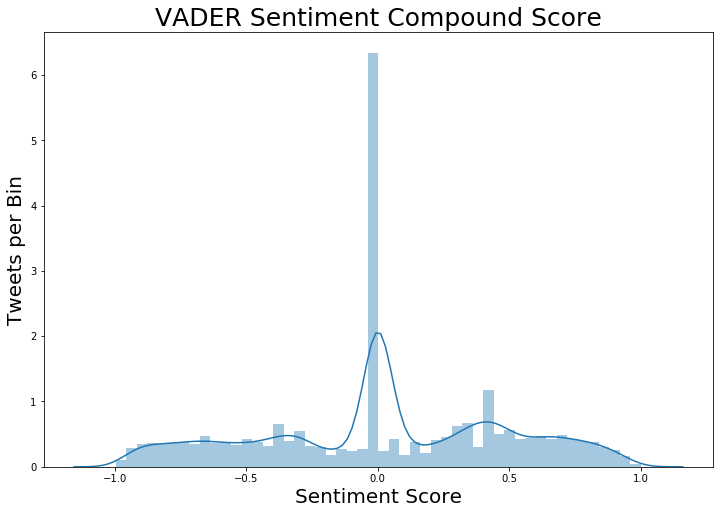

In [5]:
# plot the distribution of 'vader_score'
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(df['vader_score'])
plt.title('VADER Sentiment Compound Score', fontsize=25)
plt.xlabel('Sentiment Score', fontsize=20)
plt.ylabel('Tweets per Bin', fontsize=20)
plt.savefig('images/vader_sent_dist.png');

Looking at the graph above we see it follows a relatively normal curve, with an overwhelming amount of tweets hovering just below the net-neutral sentiment score and the rest of the tweets being more evenly distributed in both of the tails. 

Using VADER's recommended scoring method, I binned the tweets with a compound sentiment score below -.05 in the negative class, and those above .05 in the positive bin, with the remainder falling into the neutral bin.

In [6]:
# classify tweets based on their vader score less than -.05 'negative', greater than .05 'positive'
# 'neutral' in between
conditions = [
    df['vader_score'] >= .05,
    df['vader_score'] <= -.05
]

classes = ['positive', 'negative']

df['vader_sentiment'] = np.select(conditions, classes, 'neutral')

In [7]:
# breakdown of classes
df.vader_sentiment.value_counts()

positive    31095
negative    25703
neutral     20461
Name: vader_sentiment, dtype: int64

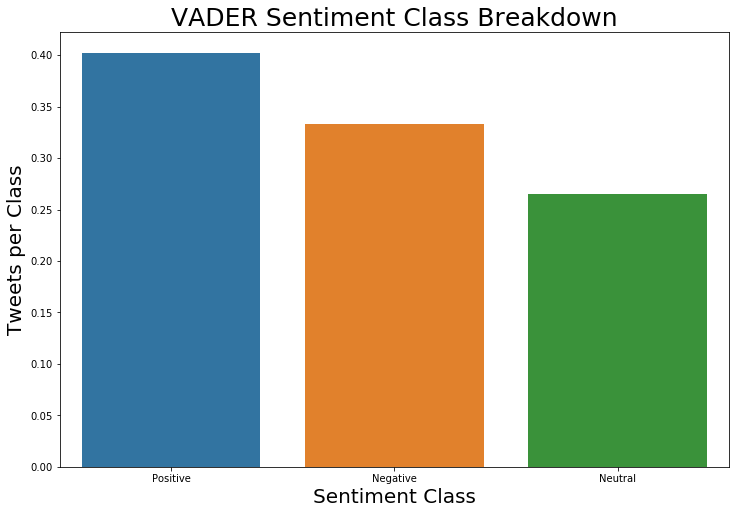

In [8]:
# plot breakdown of classes
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=['Positive', 'Negative', 'Neutral'], y=df['vader_sentiment'].value_counts(normalize=True))
plt.title('VADER Sentiment Class Breakdown', fontsize=25)
plt.xlabel('Sentiment Class', fontsize=20)
plt.ylabel('Tweets per Class', fontsize=20)
plt.savefig('images/class_bar.png');

The barchart above reveals a little bit of a class imbalance. My data is broken up into about **40% positive tweets, 35% negative tweets, and 25% neutral tweets.** This is nothing to worry about. It's not so dramatic of a difference that our classifier wouldn't be able to simply guess the majority class most of the time.

# Exploring More Extreme VADER Scoring
Simply in the name of exploration and a desire to see what exists at the more extreme poles of this sentiment scale, I've made two groups of highly positive and highly negative tweets, where I adjusted the thresholds for those sentiments to 0.5 and -0.5. Hopefully this will help me understand what the more intense ideologies are at play in this discussion over a Coronavirus vaccine.

In [9]:
highly_pos = df[df['vader_score'] >= .5]
highly_neg = df[df['vader_score'] <= -.5]

In [10]:
# drop the 'vader_score' column
df = df.drop(labels='vader_score', axis=1)

## Sentiment Over Time

In [11]:
# set a compound index using date and sentiment class to separate
df_time = df.set_index(['date', 'vader_sentiment'])

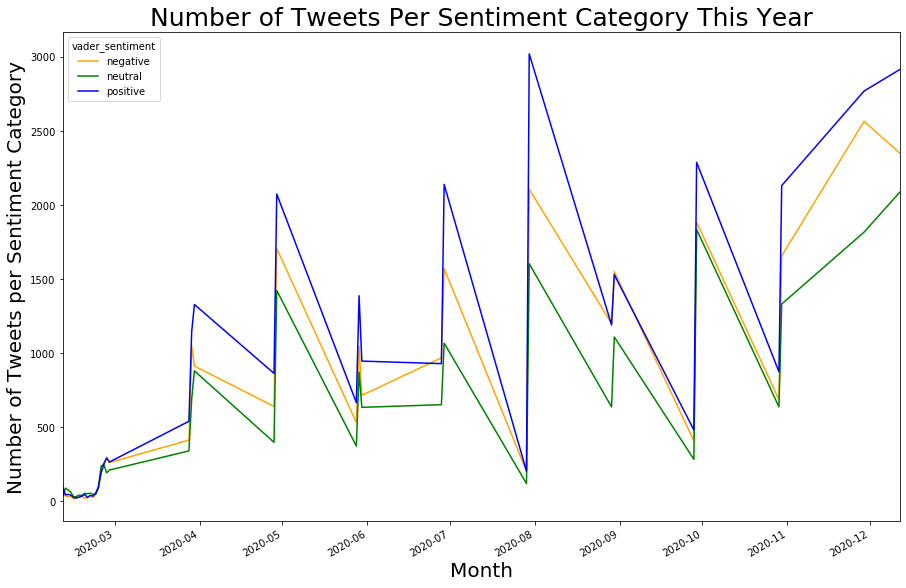

In [12]:
# plot tweet sentiment over time
fig, ax = plt.subplots(figsize=(15,10))
df_time.groupby(['date', 'vader_sentiment']).count()['tweet'].unstack().plot(
    ax=ax, color=('orange', 'green', 'blue'))
plt.title('Number of Tweets Per Sentiment Category This Year', fontsize=25)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of Tweets per Sentiment Category', fontsize=20)
plt.savefig('images/sentiment_over_time_line.png');

Key takeaways from this graph:
1) There is almost no tweeting about any vaccine until the end of March when COVID-19 really began to overwhelm the U.S.

2) The end of June and the beginning of September are the only points at which we see the amount of negative tweets exceeding the amount of positive tweets, otherwise the lines don't seem to cross each other and follow the same general trends

3) There is a general upward trend of more and more tweets about the COVID-19 vaccine as it gets closer and closer to being approved by the FDA for the public in early December

## Wordclouds, FreqDists, Bar charts of words/lemmas, a

## Preprocessing Tweets

https://stackoverflow.com/questions/62139308/preprocessing-tweets-remove-and-eliminate-stop-words-and-remove-user-from

In [15]:
nlp = English()

In [16]:
stop_words = list(set(stopwords.words('english')))

In [17]:
stop_words.extend(['covid', '#covid', 'virus', '#virus',
                   'coronavirus', '#coronavirus', 'vaccine',
                   '#vaccine', 'vaccines', '#vaccines', 'covid-19'])

In [18]:
stop_words = [w.lower() for w in stop_words]

## Text Preprocessing
After much experimentation and exploration with the preprocessing tools available to me (NLTK, SpaCy, Regex) I adapted a preprocessing function originally written by Zijing Zhu [here](https://towardsdatascience.com/a-step-by-step-tutorial-for-conducting-sentiment-analysis-a7190a444366) for preprocessing news articles. My adapted function is in the `functions.py` file in the `src` folder. 

The function takes in a string of text, lemmatizes it if it is not punctuation, removes unneeded characters and empty strings, and then rejoins the words in lowercase that are not part of my updated stopwords list.

In [19]:
def text_preprocessing(str_input): 
     # tokenization, remove punctuation, lemmatization
    words=[token.lemma_ for token in nlp(str_input) if not token.is_punct]
 
     # remove symbols, websites, email addresses 
    words = [re.sub(r'[^A-Za-z@]', '', word) for word in words] 
    words = [re.sub(r'\S+com', '', word) for word in words]
    words = [re.sub(r'\S+@\S+', '', word) for word in words] 
    words = [word for word in words if word!=' ']
    words = [word for word in words if len(word)!=0] 
 
     # remove stopwords     
    words=[word.lower() for word in words if word.lower() not in stop_words]
     # combine a list into one string   
    string = ' '.join(words)
    return string

In [20]:
# test the function on an example tweet before applying to all
text_preprocessing(df['tweet'][0])

'everyone compare flu reminder even flu kill ten thousand year imagine much deadly assurance develope affordable hello e pandemic'

In [21]:
df['clean_tweets'] = df['tweet'].apply(lambda x: text_preprocessing(x))

In [22]:
df.head()

,date,tweet,username,link,nlikes,nreplies,nretweets,vader_sentiment,clean_tweets
0,2020-02-28,"For everyone comparing COVID-19 to the flu, just a reminder that even with vaccines the flu kills tens of thousands a year. Now imagine a more dea...",MonaIbrahim,https://twitter.com/MonaIbrahim/status/1233542386669641728,3,0,0,negative,everyone compare flu reminder even flu kill ten thousand year imagine much deadly assurance develope affordable hello e pandemic
1,2020-02-28,"“Perhaps more than any other type of medicine, the success of a #vaccine depends on the cooperation of everyone. To protect those who can’t have a...",Moratel_Entles,https://twitter.com/Moratel_Entles/status/1233542196193824769,1,0,0,positive,perhaps much type medicine success depend cooperation everyone protect young promise need massive buy population large
2,2020-02-28,Provide pharmaceutical companies with the opportunity to develop this vaccine and drug as soon as possible and to reach mass production. As you kn...,help_4_Iranian,https://twitter.com/help_4_Iranian/status/1233542052161507328,0,0,0,positive,provide pharmaceutical company opportunity develop drug soon possible reach mass production know drug produce
3,2020-02-28,From John's Hopkins: 1) Immediate risk of COVID-19 remains low in the U.S. The best way to protect yourself is by practicing the same precaution...,TruthFreedom17,https://twitter.com/TruthFreedom17/status/1233541922108694528,1,1,0,positive,john hopkins immediate risk remain low us well way protect practice precaution would use prevent spread respiratory disease currently prevent
4,2020-02-28,If the #stockmarkets keep falling - how confident will you be about a #vaccine for #COVID-19 and funds being available for their development?,notarywise,https://twitter.com/notarywise/status/1233541049903177728,0,0,0,positive,stockmarkets keep fall confident fund available development


In [23]:
# saving dataframe with preprocessed tweets for use in modeling
df.to_pickle('pickle_jar/modeling_df.pkl')

In [ ]:
#################################################

## Personal

In [ ]:
def preprocess_tweet(input_string):
    # lowercase everything
    tweet = input_string.lower()
    
    # tokenize with spacy tokenizer
    tokens = [token.text for token in nlp(tweet)]
    
    # lemmatize tokens
    lemmatized = [word.lemma_ for word in tokens]
    
    # rejoin 
    tokenized_tweet = ' '.join(lemmatized)
    
    # remove stopwords
    preprocessed_tweet = ' '.join([])
    
    return preprocessed_tweet
    

In [ ]:
sample = df['tweet'][1]

In [ ]:
# lowercase the words
def lowercase(string):
    string.lower()
    return string

In [ ]:
# new column with tweet all in lowercase
df['lower_tweet'] = df['tweet'].apply(lambda x: lowercase(x))

In [ ]:
# instantiate spacy
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [ ]:
# new column with tokenized tweet
df['tokenized_tweet'] = df['lower_tweet'].apply(lambda x: tokenizer(x))

In [ ]:
# function to make list of tokens
def tokens_list(tweet):
    token_list = []
    for token in tweet:
        token_list.append(token)
    return token_list

In [ ]:
# new column with list of spacy tokens
df['tokens_list'] = df['tokenized_tweet'].apply(lambda x: tokens_list(x))

In [ ]:
# function to lemmatize spacy tokens
def lemmas_list(text):
    lemma_list = []
    for word in text:
        lemma_list.append(word.lemma_)
    return lemma_list

In [ ]:
# new column with list of lemmas
df['lemmas_list'] = df['tokens_list'].apply(lambda x: lemmas_list(x))

In [ ]:
df.head()

In [ ]:
# manually add to premade stopwords list
nlp.Defaults.stop_words |= {'covid', '#covid', 'virus', '#virus',
                            'coronavirus', '#coronavirus', 'vaccine',
                            '#vaccine', 'vaccines', '#vaccines'}

In [ ]:
# function to remove stopwords from list of lemmas
def remove_stops(list_of_tokens):
    no_stops = []
    for word in list_of_tokens:
        word.lemma_
        if word.is_stop is False:
            no_stops.append(word)
    return no_stops

In [ ]:
# new column with list of lemmas without stopwords
df['no_stops_lemms'] = df['tokens_list'].apply(lambda x: remove_stops(x))

Link to next notebook: [modeling.ipynb](http://localhost:8888/notebooks/modeling.ipynb) how do i know this is the right link? Good for local host? Or does it need to be github link?
